


### Import des libraries

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import os

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, precision_score, classification_report
from sklearn.metrics import make_scorer

import re
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

import shap

### Fonctions

In [3]:
def impute_valeurs (data, strat):
    '''Fnctions pour effectuer des imputations avec simpleImputer
    ARGS: 
        data: dataframe
        strat: la méthode à utiliser pour l'imputation des variables
    '''
    imputer = SimpleImputer(strategy=strat)
    data.iloc[:,:] = imputer.fit_transform(data)

In [4]:
def plot_roc_curve(y_real, y_pred):
    ''''Functions pour crééer une courbe ROC'''

    # Calculer les taux de faux positifs (fpr) et de vrais positifs (tpr) pour la courbe ROC
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    # Afficher la courbe ROC
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    # Définir la taille de la figure
    roc_display.figure_.set_size_inches(5, 5)
    # Tracer la ligne de référence (diagonale) en vert
    plt.plot([0, 1], [0, 1], color='g')
    plt.title('Courbe ROC')
    plt.show()

In [5]:
def conf_matrix(y_real, y_pred):
    ''''Functions pour afficher une matrice de confusion et évaluer une modèle'''

    # Calculer la matrice de confusion
    cm = confusion_matrix(y_real, y_pred)
    # Définir la taille de la figure
    plt.figure(figsize=(6, 4))
    # Afficher la matrice de confusion avec annotations, format entier, colormap 'Blues', sans barre de couleur
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Négatif Prédit', 'Positif Prédit'],
                yticklabels=['Négatif Réel', 'Positif Réel'])
    # Ajouter un titre à la figure
    plt.title('Matrice de Confusion')
    # Afficher la figure
    plt.show()

In [6]:
def classification_report_to_df(y_true, y_pred):
    """
    Convertit la sortie textuelle de classification_report en un DataFrame.
    Args :
        y_true : vraies étiquettes
        y_pred : étiquettes prédites
    """
    # Utilise output_dict=True pour obtenir le rapport de classification sous forme de dictionnaire
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    # Convertit le dictionnaire en DataFrame et transpose les lignes et colonnes
    df = pd.DataFrame(report_dict).transpose()
    return df


In [7]:
def create_results_dataframe(model_name, auc, precision,accuracy, f1):
    """
    Créer un DataFrame à partir des résultats d'évaluation du modèle.
    Args :
        model_name : Nom du modèle
        parameters : Paramètres du modèle
        auc : Score ROC AUC
        precision : Score de précision
        f1 : Score F1
    """
    # Création d'un dictionnaire avec les données des résultats
    data = {
        'Modèle': [model_name],
        'AUC': [auc],
        'Précision': [precision],
        'Accuracy': [accuracy],
        'Score F1': [f1]
    }
    # Crée un DataFrame à partir du dictionnaire
    results_df = pd.DataFrame(data)
    return results_df

### Import des données

In [8]:
# affichage des documents disponibles dans le fichier RAW_DATA
print(os.listdir("../data/processed"))

['df_train_nv.csv', 'train_enc.csv', 'test_enc.csv', 'df_test_nv.csv', 'df_test.csv', 'df_train.csv']


In [9]:
# import des données
df_train = pd.read_csv('../data/processed/df_train.csv')
df_test = pd.read_csv('../data/processed/df_test.csv')
df_train_nv = pd.read_csv('../data/processed/df_train_nv.csv')
df_test_nv = pd.read_csv('../data/processed/df_test_nv.csv')

### Préparation des données

#### Traitement des valeurs NaN

In [10]:
# imputations valeurs NaN
impute_valeurs(df_train,'median')
impute_valeurs(df_test,'median')
impute_valeurs(df_train_nv,'median')
impute_valeurs(df_test_nv,'median')

#### Split des données

In [11]:
# définition valeurs TARGET
y_train = df_train['TARGET']
X_train = df_train.drop(columns=['TARGET'], axis=1)

In [12]:
# split des valeurs train_data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [13]:
# définition valeurs TARGET
y_train_nv = df_train_nv['TARGET']
X_train_nv = df_train_nv.drop(columns=['TARGET'], axis=1)

In [14]:
# split des valeurs 
X_train_nv, X_test_nv, y_train_nv, y_test_nv = train_test_split(X_train_nv, y_train_nv, test_size=0.33, random_state=42)

#### Création sample des données pour entrainements

In [15]:
df_train.shape[0]

307511

Pour la comparaison entre modèles et leur evaluation on vas utiliser un sample de 20000 données

In [16]:
# creation sample
sample_size = (20000)
df_train_sample = df_train.sample(n=sample_size, random_state=42)

In [17]:
# définition valeurs TARGET
y_train_sample = df_train_sample['TARGET']
X_train_sample = df_train_sample.drop(columns=['TARGET'], axis=1)

In [18]:
# split des valeurs
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_train_sample, y_train_sample, test_size=0.33, random_state=42)

Vue que on as une difference importante entre les valeurs des target on vas balancer les données

In [19]:
# instancer class_weight
classes = np.unique(y_train_sample)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_sample)
class_weights_cat = dict(zip(classes, class_weights))

### Modèle naïf

Pour confronter les modèles on vas utiliser un modèle naïf

In [20]:
# fit du model naive
naive_model = GaussianNB()
naive_model.fit(X_train_sample, y_train_sample)

GaussianNB()

In [21]:
# Prédiction sur le modéle de test
y_pred_naive = naive_model.predict(X_test_sample)

In [22]:
# Evaluation du modèle
accuracy_naive = accuracy_score(y_test_sample, y_pred_naive)
roc_auc_naive = roc_auc_score(y_test_sample, y_pred_naive)
precision_naive = precision_score(y_test_sample, y_pred_naive, zero_division=1, average='weighted')
f1_naive = f1_score(y_test_sample, y_pred_naive, zero_division=1, average='weighted')

In [23]:
results_df_naive = create_results_dataframe('Modèle naïf', roc_auc_naive, precision_naive,accuracy_naive, f1_naive)
display(results_df_naive)

,Modèle,AUC,Précision,Accuracy,Score F1
0,Modèle naïf,0.5,0.925383,0.918788,0.8799


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


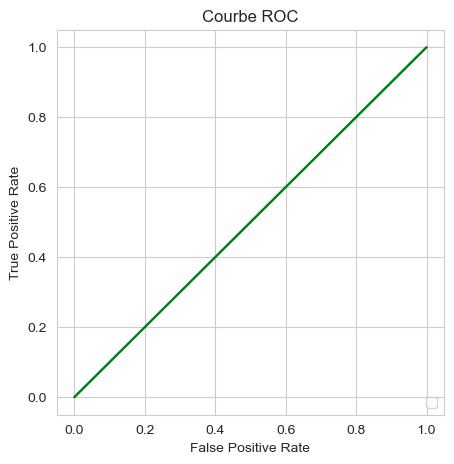

In [24]:
plot_roc_curve(y_test_sample, y_pred_naive)

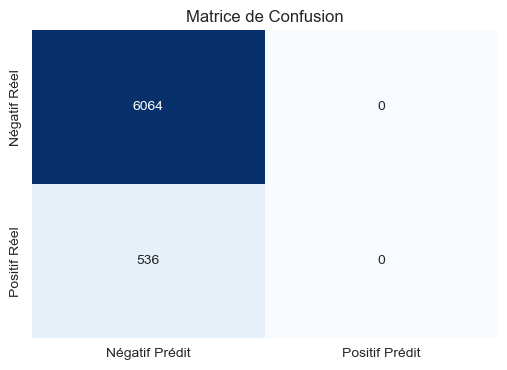

In [25]:
# afichage matrice de confusion
conf_matrix(y_test_sample, y_pred_naive)

### Test modèles

#### Régression logistique

La régression logistique est une méthode qui permet de modéliser la relation entre une variable dépendante binaire et un ensemble de variables indépendantes. Elle utilise une fonction logistique pour estimer la probabilité de l’événement. Les paramètres du modèle sont estimés en maximisant la probabilité d’observer les données réelles.

In [26]:
# Définition du pipeline avec Régression Logistique
logistic_regr = make_pipeline(LogisticRegression(max_iter=1000, class_weight={0: class_weights[0], 1: class_weights[1]}))

In [27]:
# Définition de la grille de paramètres pour GridSearchCV
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10.0],
}

In [28]:
# Définition des métriques de scoring
scoring = {
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score, zero_division=1, average='weighted'),
    'f1': make_scorer(f1_score, zero_division=1, average='weighted'),
}

In [29]:
# création GridSearchCV
grid_search = GridSearchCV(logistic_regr, param_grid, scoring=scoring, cv=5, refit='roc_auc', verbose=1)
# Entraînement du modèle
grid_search.fit(X_train_sample, y_train_sample)
# Obtention du meilleur modèle
best_model_lr = grid_search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [30]:
# Évaluation du meilleur modèle sur l'ensemble de test
y_proba_best = best_model_lr.predict_proba(X_test_sample)[:, 1]
roc_auc_rl = roc_auc_score(y_test_sample, y_proba_best)
y_pred_best = best_model_lr.predict(X_test_sample)
precision_rl = precision_score(y_test_sample, y_pred_best, zero_division=1, average='weighted')
accuracy_rl = accuracy_score(y_test_sample, y_pred_best)
f1_rl = f1_score(y_test_sample, y_pred_best, zero_division=1, average='weighted')

In [31]:
# affichage classification
classification_lr = classification_report_to_df(y_test_sample, 
                                                y_pred_best)
display(classification_lr)

,precision,recall,f1-score,support
0,0.929878,0.603562,0.732000,6064.000000
1,0.097598,0.485075,0.162500,536.000000
accuracy,0.593939,0.593939,0.593939,0.593939
macro avg,0.513738,0.544318,0.447250,6600.000000
weighted avg,0.862287,0.593939,0.685750,6600.000000


In [32]:
# affichage résultats
results_df_lr = create_results_dataframe('Régression logistique', 
                                         roc_auc_rl, 
                                         precision_rl,
                                         accuracy_rl, 
                                         f1_rl)
display(results_df_lr)

,Modèle,AUC,Précision,Accuracy,Score F1
0,Régression logistique,0.557728,0.862287,0.593939,0.68575


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


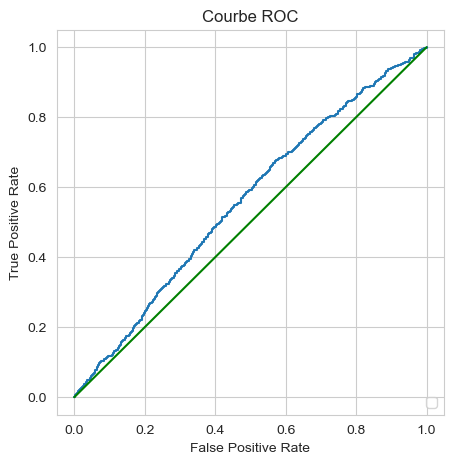

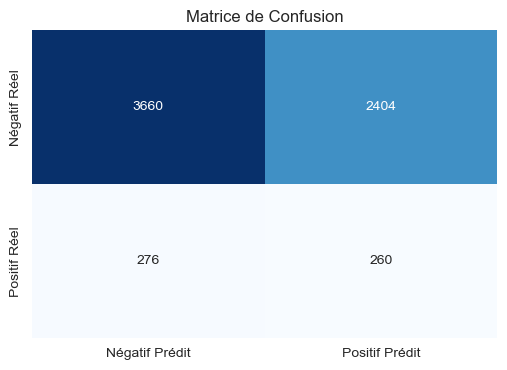

In [33]:
# Courbe ROC
plot_roc_curve(y_test_sample, y_proba_best)
# Matrice de confusion
conf_matrix(y_test_sample, y_pred_best)

### SVM Linear

Le Support Vector Machine (SVM) linéaire est un modèle d'apprentissage automatique utilisé pour la classification. Il fonctionne en trouvant un hyperplan qui sépare efficacement les différentes classes dans l'espace des caractéristiques. L'objectif est de maximiser la marge entre les classes, ce qui permet une meilleure généralisation.

In [34]:
# Définir les paramètres de la grille
param_grid = {
    'sgdclassifier__loss': ['hinge', 'log', 'modified_huber'],
    'sgdclassifier__alpha': [0.0001, 0.001, 0.01],
    'sgdclassifier__penalty': ['l2', 'l1', 'elasticnet'],
    'sgdclassifier__class_weight': ['balanced']
}

In [35]:
# Créer une pipeline avec SGDClassifier
linear_svm_pipeline = make_pipeline(SGDClassifier())

In [36]:
# Créer un objet GridSearchCV avec la pipeline et les paramètres définis
grid_search = GridSearchCV(linear_svm_pipeline, 
                           param_grid, 
                           scoring='accuracy', 
                           cv=3)
# Adapter GridSearchCV aux données d'entraînement pour rechercher les meilleurs paramètres
grid_search.fit(X_train_sample, y_train_sample)
# Obtenir le meilleur modèle trouvé
best_model_svm = grid_search.best_estimator_

In [37]:
# Prédire sur l'ensemble de test avec le meilleur modèle
y_pred_best = best_model_svm.predict(X_test_sample)
y_proba_best = best_model_svm.decision_function(X_test_sample)

In [38]:
# Évaluer les performances du meilleur modèle
accuracy_svm = accuracy_score(y_test_sample, y_pred_best)
roc_auc_svm = roc_auc_score(y_test_sample, y_proba_best)
precision_svm = precision_score(y_test_sample, y_pred_best, zero_division=1, average='weighted')
f1_svm = f1_score(y_test_sample, y_pred_best, zero_division=1, average='weighted')

In [39]:
# affichage des résultats 
classification_svm = classification_report_to_df(y_test_sample, y_pred_best)
display(classification_svm)

,precision,recall,f1-score,support
0,0.920909,0.948549,0.934525,6064.000000
1,0.118644,0.078358,0.094382,536.000000
accuracy,0.877879,0.877879,0.877879,0.877879
macro avg,0.519777,0.513454,0.514453,6600.000000
weighted avg,0.855756,0.877879,0.866295,6600.000000


In [40]:
# affichage des résultats
results_df_svm = create_results_dataframe('SVM Lineaire',
                                          roc_auc_svm, 
                                          precision_svm,
                                          accuracy_svm, 
                                          f1_svm)
display(results_df_svm)

,Modèle,AUC,Précision,Accuracy,Score F1
0,SVM Lineaire,0.573534,0.855756,0.877879,0.866295


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


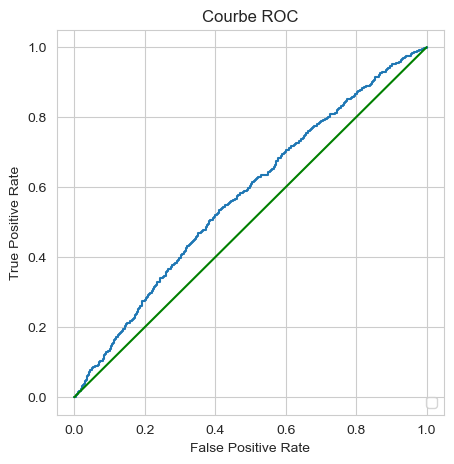

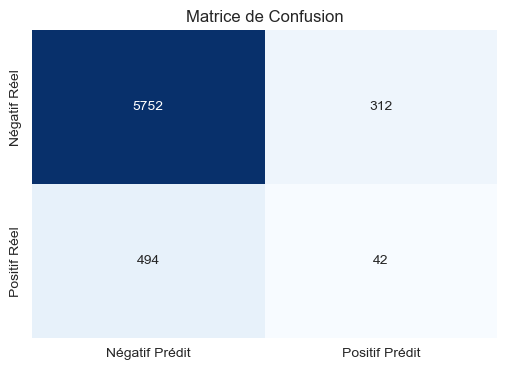

In [41]:
# Courbe ROC
plot_roc_curve(y_test_sample, y_proba_best)
# Matrice de confusion
conf_matrix(y_test_sample, y_pred_best)

### LightBGMClassifer

LightGBM Classifier utilise une approche de construction d'arbres par niveau au lieu de par profondeur, ce qui accélère le processus de formation. il est particulièrement adapté à des ensembles de données volumineux et offre une grande flexibilité pour la gestion des classes déséquilibrées.

In [42]:
# copy du df
X_train_sample_l = X_train_sample.copy()
X_test_sample_l = X_test_sample.copy()

In [43]:
# Remplacement des caracteres speciales dans les features
X_train_sample_l.columns = [re.sub(r'[^\w\s]', '_', col) for col in X_train_sample_l.columns]
X_test_sample_l.columns = [re.sub(r'[^\w\s]', '_', col) for col in X_test_sample_l.columns]

In [44]:
# parametrage
lgbm_param_grid = {
    'lgbmclassifier__n_estimators': [100, 300, 500],
    'lgbmclassifier__learning_rate': [0.01, 0.05, 0.1],
    'lgbmclassifier__num_leaves': [20, 31],
    'lgbmclassifier__feature_fraction': [0.8, 0.9]
}

In [45]:
# init lgbm classifier avec pipeline
lgbm_classifier = make_pipeline(LGBMClassifier(
    objective='binary',
    verbose=-1,
    metric='auc', 
    boosting_type='gbdt', 
    class_weight='balanced'))

In [46]:
# GridSearchCV sur le modèle
grid_search = GridSearchCV(lgbm_classifier, 
                           param_grid=lgbm_param_grid, 
                           scoring='roc_auc', 
                           cv=3)
grid_search.fit(X_train_sample_l, y_train_sample)
# Get the best hyperparameters from grid search
best_params_light = grid_search.best_params_

In [47]:
# creation et entrainement lgbm avec les paramètres meilleures
lgbm_classifier_best = LGBMClassifier(**best_params_light, 
                                      objective='binary',
                                      verbose=-1, 
                                      metric='auc', 
                                      boosting_type='gbdt', 
                                      class_weight='balanced')
lgbm_classifier_best.fit(X_train_sample_l, y_train_sample)

LGBMClassifier(class_weight='balanced', lgbmclassifier__feature_fraction=0.8,
               lgbmclassifier__learning_rate=0.01,
               lgbmclassifier__n_estimators=300, lgbmclassifier__num_leaves=20,
               metric='auc', objective='binary', verbose=-1)

In [48]:
# prédictions
y_proba = lgbm_classifier_best.predict_proba(X_test_sample_l)[:, 1]
y_pred = lgbm_classifier_best.predict(X_test_sample_l)

In [49]:
# Evaluation modèle
accuracy_light = accuracy_score(y_test_sample, y_pred)
roc_auc_light = roc_auc_score(y_test_sample, y_proba)
precision_light = precision_score(y_test_sample, y_pred, zero_division=1, average='weighted')
f1_light = f1_score(y_test_sample, y_pred, zero_division=1, average='weighted')

In [50]:
# affichage classification
classification_light = classification_report_to_df(y_test_sample, y_pred)
display(classification_light)

,precision,recall,f1-score,support
0,0.942878,0.843832,0.890610,6064.000000
1,0.192668,0.421642,0.264482,536.000000
accuracy,0.809545,0.809545,0.809545,0.809545
macro avg,0.567773,0.632737,0.577546,6600.000000
weighted avg,0.881952,0.809545,0.839761,6600.000000


In [51]:
# affichage resultats
results_df_light = create_results_dataframe('LightBGM Classifiers', roc_auc_light, precision_light,accuracy_light, f1_light)
display(results_df_light)

,Modèle,AUC,Précision,Accuracy,Score F1
0,LightBGM Classifiers,0.704241,0.881952,0.809545,0.839761


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


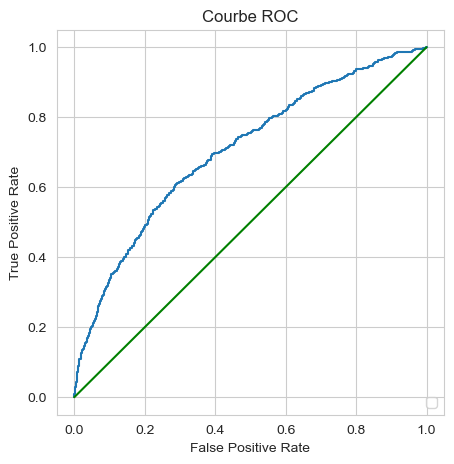

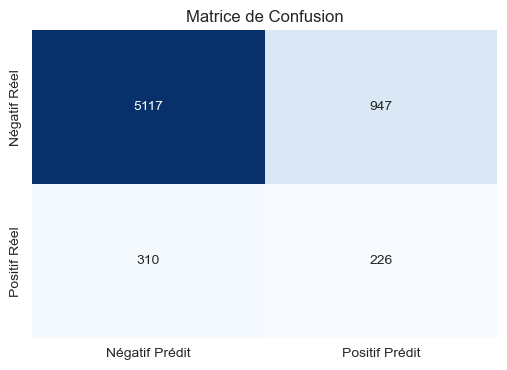

In [52]:
# affichage courbe roc
plot_roc_curve(y_test_sample, y_proba)
# matrice de confusion
conf_matrix(y_test_sample, y_pred)

### Catboost classifier

Le classificateur CatBoost est un algorithme d'apprentissage automatique basé sur le boosting qui se distingue par sa capacité à gérer naturellement les variables catégorielles sans nécessiter une préparation spécifique des données. Il utilise une technique de boosting améliorée, optimisant la performance en ajustant séquentiellement des modèles simples. CatBoost est réputé pour sa robustesse face au surajustement et est souvent utilisé dans des tâches de classification et de régression, offrant des résultats performants avec des ensembles de données complexes.

In [53]:
# Définition de la grille des paramètres à rechercher
param_grid = {
    'catboostclassifier__iterations': [1000],  # Nombre d'itérations
    'catboostclassifier__learning_rate': [0.01, 0.05, 0.1],  # Taux d'apprentissage
    'catboostclassifier__depth': [5],  # Profondeur de l'arbre
    'catboostclassifier__l2_leaf_reg': [1, 3],  # Régularisation L2
}

In [54]:
# Création de l'objet GridSearchCV avec make_pipeline
grid_search = GridSearchCV(make_pipeline(CatBoostClassifier(class_weights=class_weights_cat)),
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=3,
                           verbose=False)

In [55]:
# Entraînement de GridSearchCV sur les données d'entraînement
grid_search.fit(X_train_sample, y_train_sample)
# Obtention du meilleur modèle trouvé
best_model_cat = grid_search.best_estimator_

0:	learn: 0.6917855	total: 62.9ms	remaining: 1m 2s
1:	learn: 0.6904264	total: 67.9ms	remaining: 33.9s
2:	learn: 0.6889746	total: 71.1ms	remaining: 23.6s
3:	learn: 0.6876901	total: 74.9ms	remaining: 18.6s
4:	learn: 0.6867929	total: 78.9ms	remaining: 15.7s
5:	learn: 0.6856184	total: 83.9ms	remaining: 13.9s
6:	learn: 0.6842203	total: 87.3ms	remaining: 12.4s
7:	learn: 0.6831107	total: 92ms	remaining: 11.4s
8:	learn: 0.6818640	total: 96ms	remaining: 10.6s
9:	learn: 0.6807243	total: 99.1ms	remaining: 9.81s
10:	learn: 0.6792909	total: 104ms	remaining: 9.31s
11:	learn: 0.6781067	total: 108ms	remaining: 8.86s
12:	learn: 0.6770879	total: 111ms	remaining: 8.44s
13:	learn: 0.6760275	total: 114ms	remaining: 8.05s
14:	learn: 0.6747790	total: 117ms	remaining: 7.7s
15:	learn: 0.6737239	total: 123ms	remaining: 7.55s
16:	learn: 0.6725575	total: 127ms	remaining: 7.36s
17:	learn: 0.6715677	total: 130ms	remaining: 7.12s
18:	learn: 0.6703361	total: 134ms	remaining: 6.94s
19:	learn: 0.6691380	total: 138ms	re

In [56]:
# Prédiction sur l'ensemble de test avec le meilleur modèle
y_proba_best = best_model_cat.predict_proba(X_test_sample)[:, 1]
y_pred_best = best_model_cat.predict(X_test_sample)

In [57]:
# Évaluation des performances du meilleur modèle
accuracy_cat = accuracy_score(y_test_sample, y_pred_best)
roc_auc_cat = roc_auc_score(y_test_sample, y_proba_best)
precision_cat = precision_score(y_test_sample, y_pred_best, zero_division=1, average='weighted')
f1_cat = f1_score(y_test_sample, y_pred_best, zero_division=1, average='weighted')

In [58]:
# affichage evaluation
classification_cat = classification_report_to_df(y_test_sample, y_pred_best)
display(classification_cat)

,precision,recall,f1-score,support
0,0.953656,0.739776,0.833210,6064.000000
1,0.167722,0.593284,0.261513,536.000000
accuracy,0.727879,0.727879,0.727879,0.727879
macro avg,0.560689,0.666530,0.547361,6600.000000
weighted avg,0.889829,0.727879,0.786781,6600.000000


In [59]:
# affichage classification
results_df_cat = create_results_dataframe('Catboost Classifiers', roc_auc_cat, precision_cat,accuracy_cat, f1_cat)
display(results_df_cat)

,Modèle,AUC,Précision,Accuracy,Score F1
0,Catboost Classifiers,0.722841,0.889829,0.727879,0.786781


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


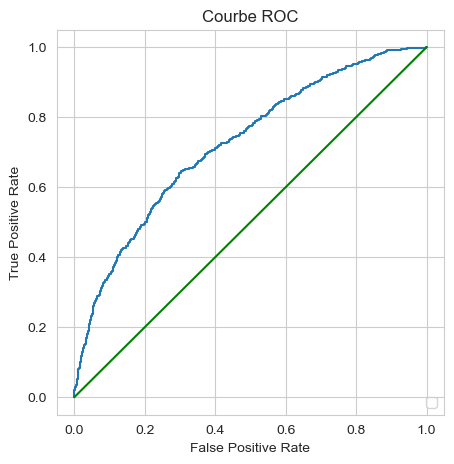

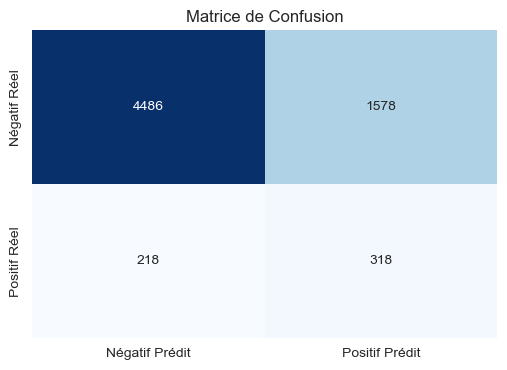

In [60]:
# Courbe ROC
plot_roc_curve(y_test_sample, y_proba_best)
# Matrice de confusion
conf_matrix(y_test_sample, y_pred_best)

### Evaluation résultats

In [61]:
# création df avec tous les résultats
resultats_modeles = pd.concat([results_df_naive,results_df_lr, results_df_svm,results_df_light, results_df_cat], ignore_index=True)

In [62]:
# affichage de tous les résultats
display(resultats_modeles)

,Modèle,AUC,Précision,Accuracy,Score F1
0,Modèle naïf,0.500000,0.925383,0.918788,0.879900
1,Régression logistique,0.557728,0.862287,0.593939,0.685750
2,SVM Lineaire,0.573534,0.855756,0.877879,0.866295
3,LightBGM Classifiers,0.704241,0.881952,0.809545,0.839761
4,Catboost Classifiers,0.722841,0.889829,0.727879,0.786781


Le modèle avec un AUC score plus élévée est le Catboost Classifier

### CatBoost Classifier avec tous le données

In [63]:
# Adapter le modèle aux données d'entraînement complet
best_model_cat.fit(X_train, y_train)

0:	learn: 0.6917720	total: 17.8ms	remaining: 17.8s
1:	learn: 0.6904260	total: 35.5ms	remaining: 17.7s
2:	learn: 0.6891484	total: 53ms	remaining: 17.6s
3:	learn: 0.6878171	total: 72.1ms	remaining: 18s
4:	learn: 0.6865484	total: 92.8ms	remaining: 18.5s
5:	learn: 0.6852829	total: 110ms	remaining: 18.1s
6:	learn: 0.6840853	total: 126ms	remaining: 17.8s
7:	learn: 0.6828686	total: 144ms	remaining: 17.8s
8:	learn: 0.6816995	total: 163ms	remaining: 18s
9:	learn: 0.6805300	total: 182ms	remaining: 18s
10:	learn: 0.6793500	total: 202ms	remaining: 18.1s
11:	learn: 0.6782614	total: 226ms	remaining: 18.6s
12:	learn: 0.6771474	total: 256ms	remaining: 19.4s
13:	learn: 0.6760493	total: 279ms	remaining: 19.6s
14:	learn: 0.6750151	total: 300ms	remaining: 19.7s
15:	learn: 0.6739639	total: 322ms	remaining: 19.8s
16:	learn: 0.6729296	total: 344ms	remaining: 19.9s
17:	learn: 0.6719416	total: 364ms	remaining: 19.8s
18:	learn: 0.6709607	total: 382ms	remaining: 19.7s
19:	learn: 0.6700288	total: 396ms	remaining:

Pipeline(steps=[('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x1668f7dd0>)])

In [64]:
# Prédire les probabilités et les étiquettes de classe sur l'ensemble de test
y_proba_best = best_model_cat.predict_proba(X_test)[:, 1]
y_pred_best = best_model_cat.predict(X_test)

In [65]:
# Évaluer les performances du meilleur modèle
accuracy_cat_fin = accuracy_score(y_test, y_pred_best)
roc_auc_cat_fin = roc_auc_score(y_test, y_proba_best)
precision_cat_fin = precision_score(y_test, y_pred_best, zero_division=1, average='weighted')
f1_cat_fin = f1_score(y_test, y_pred_best, zero_division=1, average='weighted')

In [66]:
classification_cat_fin = classification_report_to_df(y_test, y_pred_best)
display(classification_cat)

,precision,recall,f1-score,support
0,0.953656,0.739776,0.833210,6064.000000
1,0.167722,0.593284,0.261513,536.000000
accuracy,0.727879,0.727879,0.727879,0.727879
macro avg,0.560689,0.666530,0.547361,6600.000000
weighted avg,0.889829,0.727879,0.786781,6600.000000


In [67]:
# affichage classification
results_df_cat_fin = create_results_dataframe('Catboost Classifiers', roc_auc_cat_fin, precision_cat_fin,accuracy_cat_fin, f1_cat_fin)
display(results_df_cat_fin)

,Modèle,AUC,Précision,Accuracy,Score F1
0,Catboost Classifiers,0.751852,0.896733,0.698351,0.766564


On lance le même modèle pour le df avec les valeurs ajoutées

In [68]:
# Adapter le modèle aux données d'entraînement complet
best_model_cat.fit(X_train_nv, y_train_nv)

0:	learn: 0.6918657	total: 30.1ms	remaining: 30.1s
1:	learn: 0.6905072	total: 51.5ms	remaining: 25.7s
2:	learn: 0.6891848	total: 72.3ms	remaining: 24s
3:	learn: 0.6879027	total: 93.3ms	remaining: 23.2s
4:	learn: 0.6866305	total: 114ms	remaining: 22.7s
5:	learn: 0.6854055	total: 142ms	remaining: 23.5s
6:	learn: 0.6841568	total: 171ms	remaining: 24.2s
7:	learn: 0.6829522	total: 195ms	remaining: 24.2s
8:	learn: 0.6817894	total: 212ms	remaining: 23.4s
9:	learn: 0.6806273	total: 229ms	remaining: 22.7s
10:	learn: 0.6794676	total: 250ms	remaining: 22.5s
11:	learn: 0.6783742	total: 275ms	remaining: 22.6s
12:	learn: 0.6772649	total: 297ms	remaining: 22.6s
13:	learn: 0.6761652	total: 315ms	remaining: 22.2s
14:	learn: 0.6751184	total: 332ms	remaining: 21.8s
15:	learn: 0.6741101	total: 350ms	remaining: 21.5s
16:	learn: 0.6730992	total: 367ms	remaining: 21.2s
17:	learn: 0.6720948	total: 389ms	remaining: 21.2s
18:	learn: 0.6711345	total: 408ms	remaining: 21.1s
19:	learn: 0.6701665	total: 427ms	remai

Pipeline(steps=[('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x1668f7dd0>)])

In [69]:
# Prédire les probabilités et les étiquettes de classe sur l'ensemble de test
y_proba_best = best_model_cat.predict_proba(X_test_nv)[:, 1]
y_pred_best = best_model_cat.predict(X_test_nv)

In [70]:
# Évaluer les performances du meilleur modèle
accuracy_cat_fin_nv = accuracy_score(y_test_nv, y_pred_best)
roc_auc_cat_fin_nv = roc_auc_score(y_test_nv, y_proba_best)
precision_cat_fin_nv = precision_score(y_test_nv, y_pred_best, zero_division=1, average='weighted')
f1_cat_fin_nv = f1_score(y_test_nv, y_pred_best, zero_division=1, average='weighted')

In [71]:
# affichage classification
classification_cat_fin_nv = classification_report_to_df(y_test, y_pred_best)
display(classification_cat_fin_nv)

,precision,recall,f1-score,support
0,0.961578,0.709293,0.816389,93362.000000
1,0.167760,0.674017,0.268654,8117.000000
accuracy,0.706471,0.706471,0.706471,0.706471
macro avg,0.564669,0.691655,0.542521,101479.000000
weighted avg,0.898083,0.706471,0.772577,101479.000000


In [72]:
# affichage classification
results_df_cat_fin_nv = create_results_dataframe('Catboost Classifiers nv', roc_auc_cat_fin_nv, precision_cat_fin_nv,accuracy_cat_fin_nv, f1_cat_fin_nv)
display(results_df_cat_fin_nv)

,Modèle,AUC,Précision,Accuracy,Score F1
0,Catboost Classifiers nv,0.75917,0.898083,0.706471,0.772577


In [73]:
# création df avec tous les résultats
resultats_modeles_cat = pd.concat([results_df_cat_fin,results_df_cat_fin_nv], ignore_index=True)

In [74]:
# affichage comparaison
display(resultats_modeles_cat)

,Modèle,AUC,Précision,Accuracy,Score F1
0,Catboost Classifiers,0.751852,0.896733,0.698351,0.766564
1,Catboost Classifiers nv,0.759170,0.898083,0.706471,0.772577


Le modèle avec les nouveaux valeurs performe mieux que l'autre, on vas alors utiliser la libraries shap pou expliquer le modèle

### Shap

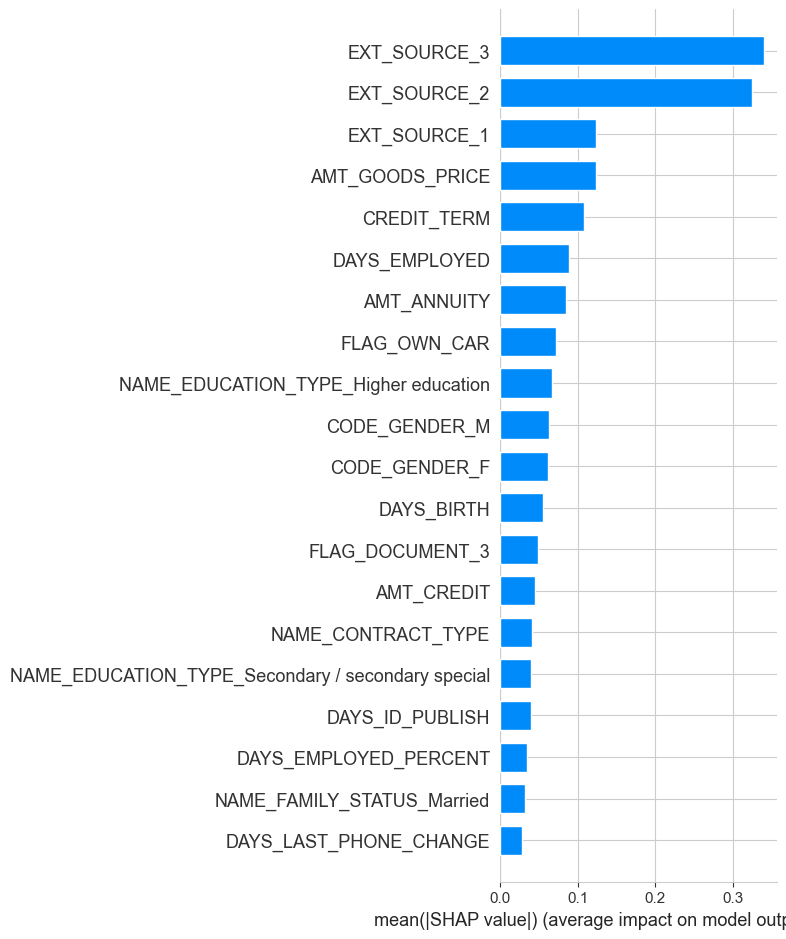

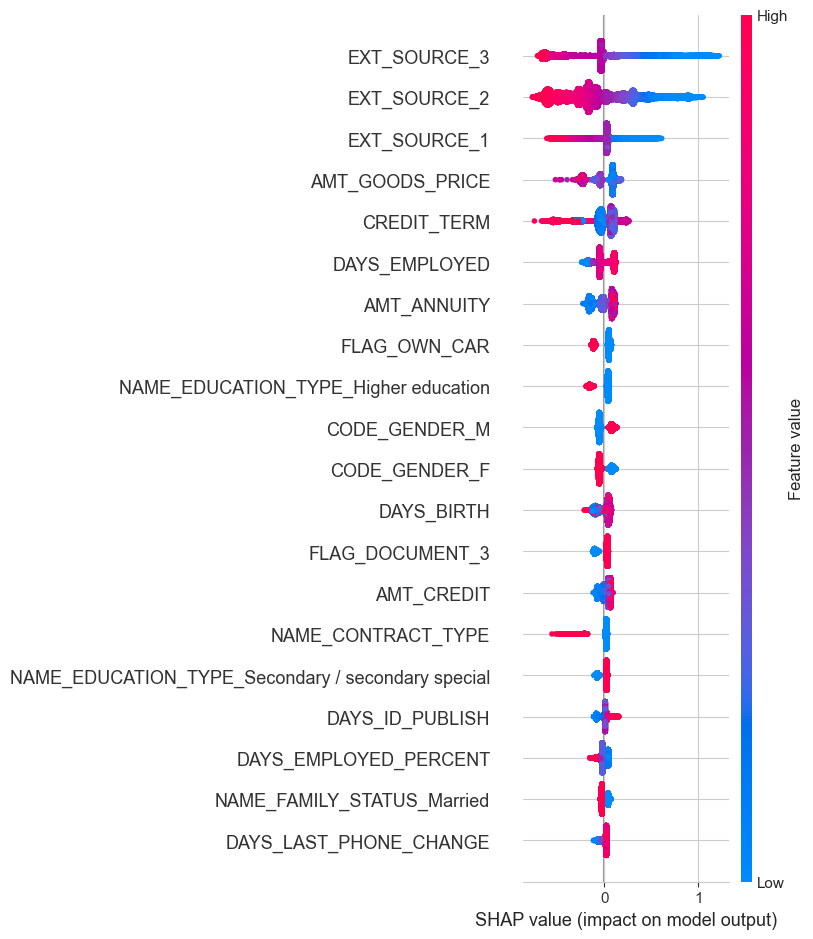

In [75]:
# Obtenir le modèle CatBoost à partir du pipeline
catboost_model = best_model_cat.named_steps['catboostclassifier']

# Créer un explainer SHAP avec le modèle CatBoost
explainer = shap.Explainer(catboost_model)

# Calculer les valeurs SHAP pour les données de test
shap_values = explainer.shap_values(X_test_nv)

# Afficher les graphiques SHAP
shap.summary_plot(shap_values, X_test_nv, plot_type="bar")  # Pour un graphique de résumé avec les valeurs SHAP
shap.summary_plot(shap_values, X_test_nv)  # Pour un graphique de résumé sans les valeurs SHAP


Les colonnes des notation des ```EXT_SOURCE``` répresentent les colonnes plus importantes dans l'entrainement du modèle est c'est attendu car elles representent des notes externet sur le comportement des clients qui indiquent si ils vont ou pas payer leur dettes.

### Meilleur Seuil

In [76]:
def score_metier(y_true, y_proba, cost_fp, cost_fn):
    '''fonction pour déterminer le meilleur seuil métier'''

    # recherche seuil entre 0.1 et 1.0
    seuils = np.arange(0.1, 1.0, 0.01)

    # init des metrics
    best_score = float('inf') 
    meilleure_seuil = None

    # parcours des différents seuils
    for seuil in seuils:
        y_pred = (y_proba >= seuil).astype(int)
        
        # MC entre les vrais labels et les pred
        cm = confusion_matrix(y_true, y_pred)

        # coût total du modèle en fonction du seuil
        total_cost = cm[0, 1] * cost_fp + cm[1, 0] * cost_fn

        if total_cost < best_score:
            best_score = total_cost
            meilleure_seuil = seuil

    return meilleure_seuil, best_score

In [77]:
# on etablie les poids des valeurs
cost_fp = 1
cost_fn = 10

In [78]:
# init méthode 
meilleure_seuil, best_score = score_metier(y_test_nv, y_proba_best, cost_fp, cost_fn)

In [79]:
# affichage meilleure seuil à utiliser
print('Meilleure seuil à utiliser pout entrainair le modèle est de', round(meilleure_seuil,3))

Meilleure seuil à utiliser pout entrainair le modèle est de 0.52


### Modéle sur le DF de test et sauvegarde

In [80]:
# Utiliser le modèle entraîné pour obtenir les probabilités prédites sur le jeu de données de test (df_test_nv)
predicted_probabilities = best_model_cat.predict_proba(df_test_nv)[:, 1]

In [81]:
# Appliquer un seuil aux probabilités prédites
threshold = meilleure_seuil
predictions = (predicted_probabilities >= threshold).astype(int)

In [82]:
# creation df avec id et target
df_results = pd.DataFrame({
    'SK_ID_CURR': df_test_nv['SK_ID_CURR'],
    'TARGET': predictions
})

In [83]:
# affichage du df
display(df_results.head(5))

,SK_ID_CURR,TARGET
0,100001,0
1,100005,1
2,100013,0
3,100028,0
4,100038,1


In [84]:
# Sauvegarder les résultats dans un fichier CSV 
df_results.to_csv('resultats_predictions.csv', index=False)